In [2]:
import pdb
import traceback

import jax
from jax import jit
from jax import numpy as jnp
import optax
import wandb
import equinox as eqx
from inr_utils.images import make_lin_grid


from common_dl_utils.config_creation import Config
import common_jax_utils as cju
import neural_tangents as nt
wandb.login()

key = jax.random.PRNGKey(12398)
key_gen = cju.key_generator(key)

2025-01-06 16:48:43.025255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736178523.076057    2979 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736178523.090095    2979 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: maxwell_litsios (bep-circle). Use `wandb login --relogin` to force relogin


In [146]:
config = Config()

# first we specify what the model should look like
config.architecture = './model_components'  # module containing all relevant classes for architectures
# NB if the classes relevant for creating the model are spread over multiple modules, this is no problem
# let config.architecture be the module that contains the "main" model class, and for all other components just specify the module
# or specify the other modules as default modules to the tools in common_jax_utils.run_utils
config.model_type = 'inr_modules.CombinedINR'

config.model_config = Config()
config.model_config.in_size = 2
config.model_config.out_size = 2
config.model_config.terms = [  # CombinedINR uses multiple MLPs and returns the sum of their outputs. These 'terms' are the MLPs
    ('inr_modules.MLPINR.from_config',{
        'hidden_size': 1028,
        'num_layers': 3,
        'layer_type': 'inr_layers.GaussianINRLayer',
        # 'layer_type': 'inr_layers.ComplexWIRE',
        'num_splits': 1,
        # 'activation_kwargs': {'w0': 25., "s0":15},
        'activation_kwargs': {'inverse_scale': 1},
        'initialization_scheme':'initialization_schemes.siren_scheme',
        'initialization_scheme_kwargs': {'w0': 12.}
        # 'positional_encoding_layer': ('inr_layers.ClassicalPositionalEncoding.from_config', {'num_frequencies': 10}),
    }),
    # ('inr_modules.MLPINR.from_config',{
    #     'hidden_size': 1024,
    #     'num_layers': 2,
    #     'num_splits': 1,
    #     'layer_type': 'inr_layers.GaussianINRLayer',
    #     'use_complex': False,
    #     'activation_kwargs': {'inverse_scale': 1},
    # })
]
config.model_config.post_processor = lambda x: x[0]

In [147]:
def apply_inr(inr, location):
    return inr(location)

inr_grad = eqx.filter_grad(apply_inr)

In [148]:
def prep_x_ys(n = 10):

    locations = make_lin_grid(0., 1., (n, n))
    location_dims = locations.shape
    in_channels = location_dims[-1]
    out_channels = 2
    flattened_locations = locations.reshape(-1, in_channels)
    #rgb_vals = random.uniform(next(key_gen), (flattened_locations.shape[0], out_channels), minval=0, maxval=1)
    rgb_vals = jnp.sin(2*jnp.pi* flattened_locations)


    return flattened_locations, in_channels, rgb_vals, out_channels


flatten_locs, in_channels, _, _ = prep_x_ys(10)



In [149]:

def make_mlp():
    try:
        inr = cju.run_utils.get_model_from_config_and_key(
            prng_key=next(key_gen),
            config=config,
            model_sub_config_name_base='model',
            add_model_module_to_architecture_default_module=False, # since the model is already in the default module specified by 'architecture',
        )
    except Exception as e:
        traceback.print_exc()
        print(e)
        print('\n')
        pdb.post_mortem()
        

    params, static = eqx.partition(inr, eqx.is_inexact_array)

    def init_fn():
        return params

    def apply_fn(_params, x):
        model = eqx.combine(_params, static)
        return model(x)

    return init_fn, jax.vmap(apply_fn, (None, 0))

init_fn, apply_fn = make_mlp()




In [150]:
kwargs = dict(
        f=apply_fn,
        trace_axes=(),
        vmap_axes=0
    )
jacobian_contraction = jit(nt.empirical_ntk_fn(**kwargs, implementation=nt.NtkImplementation.JACOBIAN_CONTRACTION))
ntvp = jit(nt.empirical_ntk_fn(**kwargs, implementation=nt.NtkImplementation.NTK_VECTOR_PRODUCTS))
auto = jit(nt.empirical_ntk_fn(**kwargs, implementation=nt.NtkImplementation.AUTO))

In [151]:
params = init_fn()
params


CombinedINR(
  terms=(
    MLPINR(
      layers=(
        GaussianINRLayer(
          weights=f32[1028,2],
          biases=f32[1028],
          activation_kwargs={'inverse_scale': 1}
        ),
        GaussianINRLayer(
          weights=f32[1028,1028],
          biases=f32[1028],
          activation_kwargs={'inverse_scale': 1}
        ),
        Linear(weights=f32[2,1028], biases=f32[2], activation_kwargs={})
      )
    ),
  ),
  post_processor=None
)

In [152]:
    

k_1 = jacobian_contraction(flatten_locs, flatten_locs, params)

In [153]:
k_2 = ntvp(flatten_locs, flatten_locs, params)


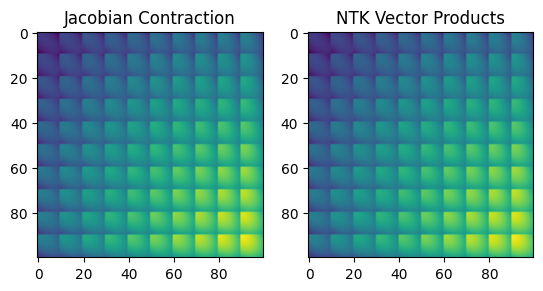

In [154]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].imshow(k_1)
ax[0].set_title('Jacobian Contraction')
ax[1].imshow(k_2)
ax[1].set_title('NTK Vector Products')

plt.show()



In [155]:
import matplotlib.pyplot as plt




In [158]:
eigvals, eigvecs = jnp.linalg.eigh(k_2)

In [159]:
rescaled_eigvals = eigvals / jnp.min(jnp.abs(eigvals))



(array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-5.35354785e+03,  3.97086310e+09,  7.94173184e+09,  1.19126006e+10,
         1.58834688e+10,  1.98543360e+10,  2.38252052e+10,  2.77960724e+10,
         3.17669417e+10,  3.57378130e+10,  3.97086802e+10]),
 <BarContainer object of 10 artists>)

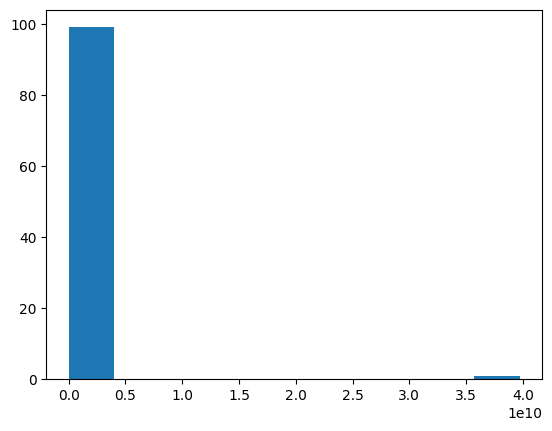

In [160]:
plt.hist(rescaled_eigvals)